In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%matplotlib inline

# IMPORTS:
import numpy as np
import mceq_config as config
from MCEq.core import MCEqRun
import crflux.models as pm
import matplotlib.pyplot as plt
import MCEq.geometry.density_profiles as den_p
import MCEq.geometry.geometry as geom

# MUTE
import mute.constants as mtc
import mute.surface as mts
import mute.propagation as mtp
import mute.underground as mtu

In [3]:
color_list = [ 'tab:red','tab:orange', 'tab:green','tab:blue',  'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
from matplotlib import gridspec
from IPython.display import display, Image
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
import pandas as pd
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['lines.marker'] = ','
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.linestyle'] = '-'
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['figure.figsize'] = [10.0, 8.0]
mpl.rcParams['savefig.transparent'] = False
mpl.rcParams['savefig.facecolor'] = 'w'
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['legend.markerscale']=1.5
mpl.rcParams['legend.fontsize']=20
mpl.rcParams['legend.title_fontsize']=20

/tmp/ipykernel_60995/3958237280.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
## Bugaev model as in https://arxiv.org/abs/1906.02704 ##:
def IntFlux(d) -> float:
    A_1=1.31*1e-5
    A_2=-2.91*1e-3
    A_3=7.31*1e-7
    A_4=-1.17*1e-3
    B_1=4.16*1e-1
    B_2=1.07*1e-4
    IntF=np.divide(
        A_1*np.exp(A_2*d)+A_3*np.exp(A_4*d),
        B_1+B_2*d
    )
    return IntF

# Definition and visualisation of the two potential sites

In [5]:
# Skład materiałów wybuchowych: 
explosives_storage = {
    'depth':np.array([14.5,38.,120.,140.,164.,206.]), # in m below the ground
    'density':np.array([2120.,2130.,2144.15,2095.65,2144.15,2067.42]), # in kg/m3
}

"""
location:
(DD.DDDD) 49,9817 N (latitude)         20,0501 E (longitude)
(DD.MMSS) 49,5854 N (latitude)         20,0301 E (longitude)

elevation:
253 m n.p.m.

location name in modified MCEq code: "Wieliczka_Explosives"
"""
print('')

In [6]:
# Podszybie szybu Kinga na poziomie VIII:
kinga_shaft = {
    'depth':np.array([14.5,37.5,98.,123.,152.5,286.]), # in m below the ground
    'density':np.array([2120.,2130.,2144.15,2095.65,2144.15,2067.42]), # in kg/m3
}

'''
location:
(DD.DDDD) 49,9832 N          20,0518 E
(DD.MMSS) 49,5859 N          20,0307 E

elevation:
243 m n.p.m.

location name in modified MCEq code: "Wieliczka_Kinga"
'''
print('')

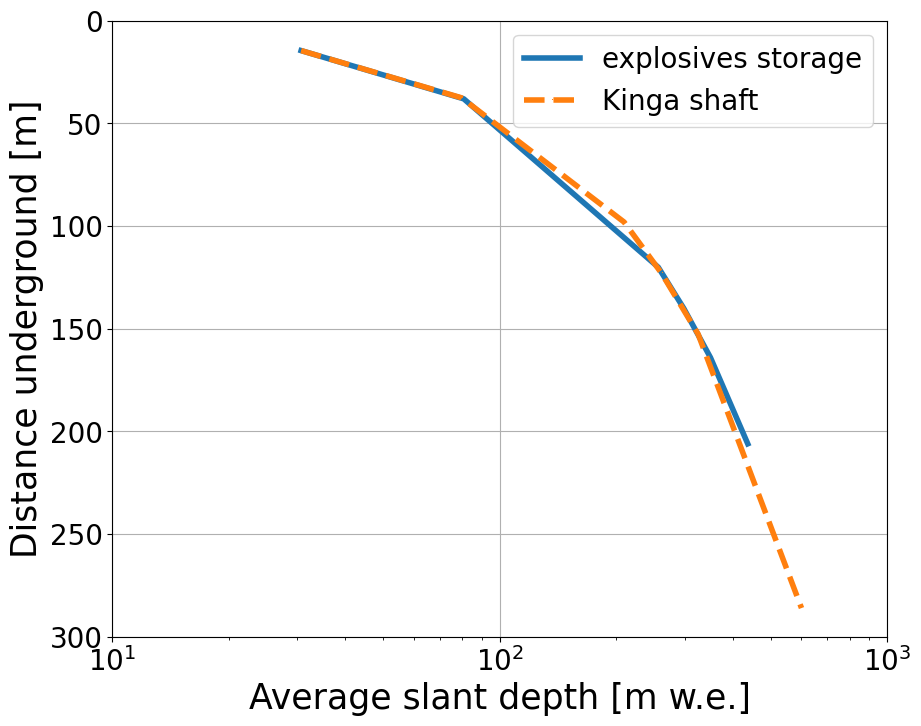

In [7]:
plt.grid()
plt.plot(
    np.cumsum(np.diff(np.append(0,explosives_storage['depth']))*explosives_storage['density'])*0.1*1e-2, # 0.1 to convert to g/cm2, 1e-2 to convert to m
    explosives_storage['depth'],
    label='explosives storage',
)
plt.plot(
    np.cumsum(np.diff(np.append(0,kinga_shaft['depth']))*kinga_shaft['density'])*0.1*1e-2, # 0.1 to convert to g/cm2, 1e-2 to convert to m
    kinga_shaft['depth'],
    label='Kinga shaft',ls='--'
)
plt.gca().invert_yaxis()
plt.xlabel("Average slant depth [m w.e.]")
plt.ylabel("Distance underground [m]")
plt.legend()
plt.semilogx()
plt.xlim(1e1,1e3)
plt.ylim(300,0)['depth']
for fmt in ['png','pdf','svg']:
    plt.savefig('plots/slant_depth_vs_distance_logx.'+fmt)
plt.show()

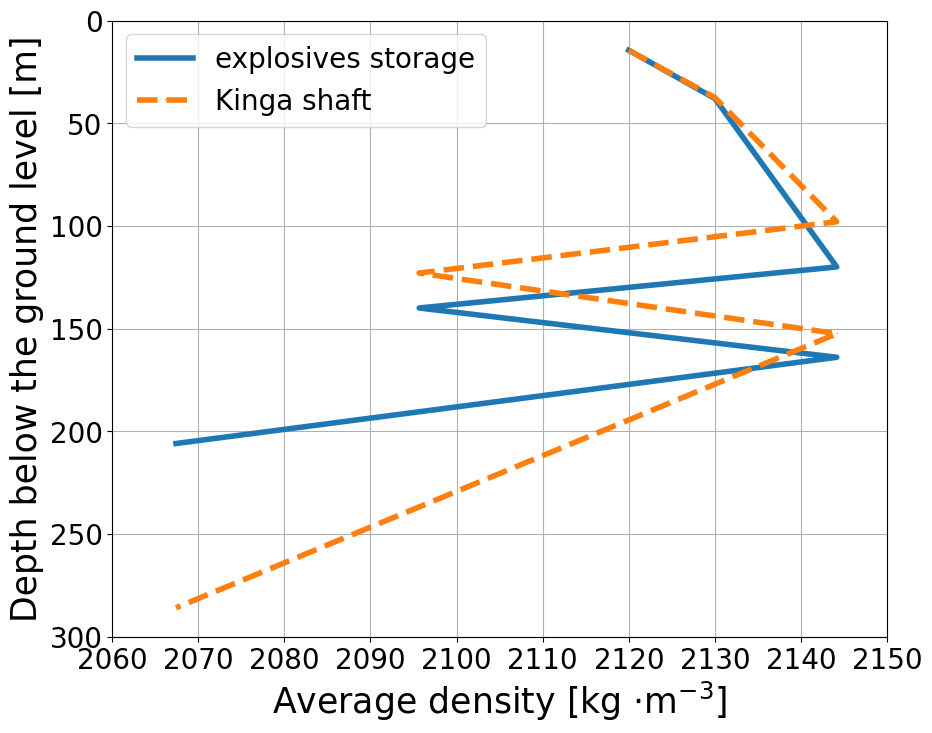

In [7]:
plt.grid()
plt.plot(explosives_storage['density'],explosives_storage['depth'],label='explosives storage')
plt.plot(kinga_shaft['density'],kinga_shaft['depth'],label='Kinga shaft',ls='--')
plt.gca().invert_yaxis()
plt.xlabel("Average density [kg $\cdot $m$^{-3}$]")
plt.ylabel("Depth below the ground level [m]")
plt.legend()
plt.ylim(300,0)
plt.xlim(2060,2150)
for fmt in ['png','pdf','svg']:
    plt.savefig('plots/avg_density.'+fmt)
plt.show()

# Compute fluxes with MCEq/MUTE

### Set the constants

In [8]:
mtc.set_verbose(2)
mtc.set_output(True)
mtc.set_lab("Example")
mtc.set_overburden("flat")
mtc.set_vertical_depth(3.7)
mtc.set_medium("rock")
mtc.set_density(2.65)
mtc.set_n_muon(100000)
mtc.interaction_model="SIBYLL-2.3d"
mtc.atmosphere="MSIS00",
mtc.location="Wieliczka_Explosives",
mtc.month="January",
mtc.primary_model="GSF" # GSF - Global Spline Fit
mtc.shallow_extrapolation = True

## Calculate true vertical intensities for the default slant depths and atmosphere

In [9]:
intensities_DDM = mtu.calc_u_intensities(method = "tr", interaction_model = "DDM")
intensities_SIBYLL = mtu.calc_u_intensities(method = "tr", interaction_model = "SIBYLL-2.3d")
intensities_GSF = mtu.calc_u_intensities(method = "tr", primary_model = "GSF") # GlobalSplitFitBeta
intensities_HG  = mtu.calc_u_intensities(method = "tr", primary_model = "HG")  # HillasGaisser2012
intensities_GH  = mtu.calc_u_intensities(method = "tr", primary_model = "GH")  # GaisserHonda
intensities_ZS  = mtu.calc_u_intensities(method = "tr", primary_model = "ZS")  # ZatsepinSokolskaya

Calculating underground fluxes.
Loading surface fluxes for USStd using GSF and DDM.
Loaded surface fluxes.
Loading survival probabilities from /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/survival_probabilities/rock_2.65_100000_Survival_Probabilities.txt.
Loaded survival probabilities.
Finished calculating underground fluxes.
Calculating true vertical underground intensities.
Finished calculating true vertical underground intensities.
True vertical underground intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Intensities_tr.txt.
Calculating underground fluxes.
Loading surface fluxes for USStd using GSF and SIBYLL-2.3d.
Loaded surface fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Calculating true vertical underground intensities.
Finished calculating true vertical underground intensities.


## Calculate underground fluxes

In [10]:
# for Energy plot:
mtc.set_verbose(2)
mtc.set_output(True)
mtc.set_lab("Example")
mtc.set_overburden("flat")
mtc.set_vertical_depth(3.7)
mtc.set_medium("rock")
mtc.set_density(2.65)
mtc.set_n_muon(100000)
mtc.interaction_model="SIBYLL-2.3d"
mtc.atmosphere="MSIS00",
mtc.location="Wieliczka_Explosives",
mtc.month="January",
mtc.primary_model="GSF" # GSF - Global Spline Fit
mtc.shallow_extrapolation = True
mtc.set_vertical_depth(0.5)
u_fluxes_full = mtu.calc_u_fluxes(full_tensor = True)
# u_fluxes_full: (slant depths, underground energies,zenith angles)  i.e. fluxes corresponding to mtc.ENERGIES, mtc.ANGLES_FOR_S_FLUXES


print(u_fluxes_full[0, :5, :5])
print(u_fluxes_full.shape)

Calculating underground fluxes.
Loading surface fluxes for USStd using GSF and SIBYLL-2.3c.
Loaded surface fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Underground fluxes written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Fluxes.txt.
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [5.40109447e-11 5.40751625e-11 5.42782299e-11 5.46175089e-11
  5.50734247e-11]
 [1.34487970e-10 1.34649717e-10 1.35160145e-10 1.36013422e-10
  1.37161474e-10]
 [2.13325466e-10 2.13579177e-10 2.14381511e-10 2.15722044e-10
  2.17523509e-10]
 [2.25263220e-10 2.25532132e-10 2.26381881e-10 2.27801891e-10
  2.29710915e-10]]
(28, 91, 20)


In [11]:
# for slant depth plot:
depths=np.arange(0.01,1.51,0.1)
u_fluxes_integrated=[]
for depth in depths: # in km w. e.
    mtc.set_vertical_depth(depth)
    u_fluxes_integrated.append(mtu.calc_u_tot_flux(
        force = False, s_fluxes = None, survival_probability_tensor = None, 
        angles = mtc.angles, 
        E_th = 0, 
        primary_model = "GSF", interaction_model = "SIBYLL-2.3c", atmosphere = "MSIS00", location = "Wieliczka_Explosives", month = "January")
    )

Calculating underground fluxes.
Loading surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
Loaded surface fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Calculating underground intensities.
Finished calculating underground intensities.
Underground intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Intensities_sd.txt.
Calculating underground fluxes.
Loading surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
Loaded surface fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Calculating underground intensities.
Finished calculating underground intensities.
Underground intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Intensitie

## Calculate surface fluxes

In [12]:
surface_flux=mts.calc_s_fluxes(
    primary_model = "GSF", interaction_model = "SIBYLL-2.3c", 
    atmosphere = "MSIS00", location = "Wieliczka_Explosives", month = "January", 
    output = None, file_name = "", force = False, test = False
)

Calculating surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
MCEqRun::set_interaction_model(): SIBYLL23C
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::set_density_model(): Setting density profile to MSIS00 ('Wieliczka_Explosives', 'January')


100%|██████████| 20/20 [04:13<00:00, 12.70s/it]


Finished calculating surface fluxes.
Surface fluxes written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Fluxes_Wieliczka_Explosives_January_SIBYLL-2.3c_GSF.txt.


In [13]:
# compute surface neutron flux with MCEq directly:
mceq_run = MCEqRun(
    interaction_model='SIBYLL23C', # High-energy hadronic interaction model
    # primary_model = (pm.GaisserStanevTilav,'3-gen'), # cosmic ray flux at the top of the atmosphere
    primary_model = (pm.GlobalSplineFitBeta,None),
    # density_model = ('CORSIKA',("KM3NeT", None)), # atmosphere model
    density_model = ('MSIS00',("Wieliczka_Explosives", "January")), # atmosphere model
    theta_deg = 0. # zenith angle
)
mceq_run.solve()

MCEqRun::set_interaction_model(): SIBYLL23C
MCEqRun::set_density_model(): Setting density profile to MSIS00 ('Wieliczka_Explosives', 'January')
MCEqRun::set_primary_model(): GlobalSplineFitBeta 


In [14]:
s_flux_integrated=mts.calc_s_tot_flux(
    force = False,primary_model = "GSF", interaction_model = "SIBYLL-2.3c", 
    atmosphere = "MSIS00", location = "Wieliczka_Explosives", month = "January", 
)

Calculating total surface flux.
Calculating surface intensities.
Loading surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
Loaded surface fluxes.
Finished calculating surface intensities.
Surface intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Intensities_Wieliczka_Explosives_January_SIBYLL-2.3c_GSF.txt.
Finished calculating total surface flux.


## Plots

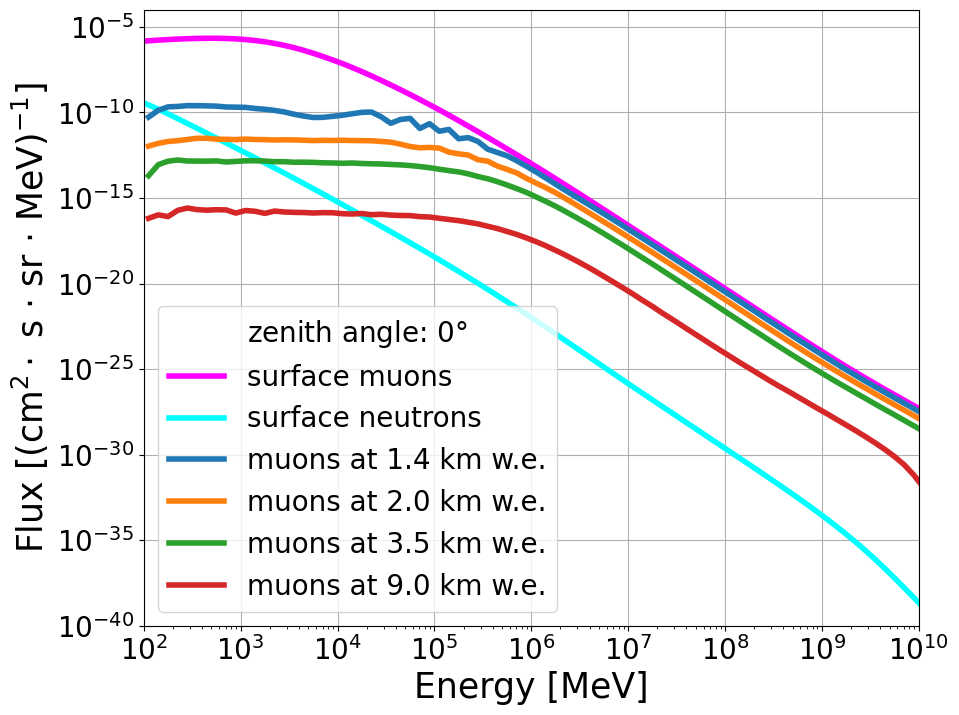

In [15]:
# Plot the results
j=0 # mtc.ANGLES_FOR_S_FLUXES index
plt.figure(facecolor = "white")
plt.grid()
plt.loglog(mtc.ENERGIES, surface_flux[:,1], color = "magenta", label = "surface muons")
plt.loglog(mceq_run.e_grid, mceq_run.get_solution('n0',mag=0), color = "cyan", label = "surface neutrons")

for i in [0,2,5,16]:
    slc=u_fluxes_full[i,:,j]>0
    plt.loglog(mtc.ENERGIES[slc], u_fluxes_full[i,:,j][slc], label = "muons at "+str(mtc.slant_depths[i].round(1))+" km w.e.")
# plt.semilogy(mtc.slant_depths, intensities_DDM, color = "blue", label = "DDM")

# plt.plot(mtc.slant_depths, intensities_HG, color = "red", lw = 3, ls = "-", label = "HillasGaisser2012")
# plt.plot(mtc.slant_depths, intensities_GH, color = "blue", lw = 3, ls = "--", label = "GaisserHonda")
# plt.plot(mtc.slant_depths, intensities_ZS, color = "green", lw = 3, ls = ":", label = "ZatsepinSokolskaya")
# plt.plot(mtc.slant_depths, intensities_GSF, color = "teal", lw = 3, ls = ":", label = "GSF")
# plt.xlabel("Slant Depth, $X$ [km.w.e.]")
plt.xlabel("Energy [MeV]")
plt.ylabel("Flux [(cm$^2 \cdot$ s $\cdot$ sr $\cdot$ MeV)$^{-1}$]")
plt.xlim(1e2,1e10)
plt.ylim(1e-40,1e-4)
# plt.text(x=1e7,y=1e-6,s="location: Wieliczka",fontsize=18,color='grey')
plt.legend(title="zenith angle: "+str(int(mtc.ANGLES_FOR_S_FLUXES[j]))+"$\degree$")
for fmt in ['png','pdf','svg']:
    plt.savefig('plots/flux_vs_energy.'+fmt)
plt.show()

In [25]:
## Bugaev model as in https://arxiv.org/abs/1906.02704 ##:
Bugaev=IntFlux(np.asarray(np.append(0,depths))*1e3)

In [36]:
Bugaev_line=pd.DataFrame({
        'depths':1e3*np.append(0,depths), 
        'Bugaev':Bugaev,
        'Bugaev_lower':Bugaev*0.92,
        'Bugaev_upper':Bugaev*1.08,
})
MUTE_line=pd.DataFrame({
    'depths':1e3*np.append(0,depths), 
    'MUTE':np.append(s_flux_integrated,u_fluxes_integrated),
    'MUTE_lower':np.append(s_flux_integrated,u_fluxes_integrated)*(1.+pd.read_csv('data/uncertainty_total.csv')['lower']),
    'MUTE_upper':np.append(s_flux_integrated,u_fluxes_integrated)*(1.+pd.read_csv('data/uncertainty_total.csv')['upper']),
})

Save the lines to file:

In [38]:
Bugaev_line.to_csv('data/Bugaev_int_flux_vs_depth.csv', index=False)
MUTE_line.to_csv('data/MUTE_int_flux_vs_depth.csv', index=False)

Plot the flux vs depth

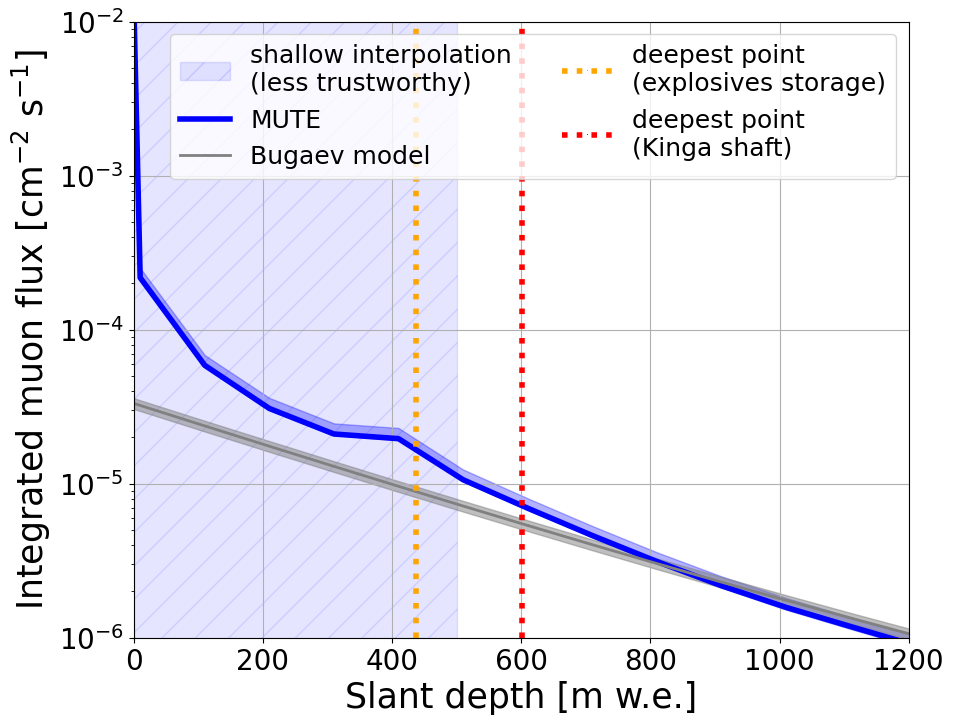

In [39]:
# Plot the results

plt.figure(facecolor = "white")
plt.grid()
plt.fill_between([-50.,500.], 1e-10,1e0, color = "blue",alpha=0.1,
                 label='shallow interpolation\n(less trustworthy)',hatch="/")
plt.fill_between(MUTE_line['depths'], 
                 y1=MUTE_line['MUTE_lower'],
                 y2=MUTE_line['MUTE_upper'], 
                 color = "blue",alpha=0.3)

plt.semilogy(MUTE_line['depths'], MUTE_line['MUTE'], color = "blue", label = "MUTE")

plt.fill_between(Bugaev_line['depths'], 
                 y1=Bugaev_line['Bugaev_lower'],
                 y2=Bugaev_line['Bugaev_upper'], color = "grey",alpha=0.5) # +/- 8%, as stated in the paper
plt.semilogy(Bugaev_line['depths'], Bugaev_line['Bugaev'], color = "grey", label = "Bugaev model",lw=2)
#########################################################

plt.axvline(np.sum(np.diff(np.append(0,explosives_storage['depth']))*explosives_storage['density'])*0.1*1e-2,color='orange',ls=':',label='deepest point\n(explosives storage)')
plt.axvline(np.sum(np.diff(np.append(0,kinga_shaft['depth']))*kinga_shaft['density'])*0.1*1e-2,color='red',ls=':',label='deepest point\n(Kinga shaft)')

plt.xlabel("Slant depth [m w.e.]")
plt.ylabel("Integrated muon flux [cm$^{-2}$ s$^{-1}$]")
plt.xlim(0,1200)
plt.ylim(1e-6,1e-2)
plt.legend(fontsize=18,ncols=2)
for fmt in ['png','pdf','svg']:
    plt.savefig('plots/integrated_mu_flux.'+fmt)
plt.show()

## Systematic uncertainties

In [40]:
# all uncertainties are for the I vs slant depth plot
depths=np.arange(0.01,1.51,0.1)

### had

In [70]:
HADMODELS = [
    "SIBYLL-2.3c",
    "EPOS-LHC",
    "QGSJet-II-04",
    "DPMJET-III-19.1",
]
hadfluxes={k:None for k in HADMODELS}
for had in HADMODELS:
    s_flux_integrated=mts.calc_s_tot_flux(
        force = False,primary_model = "GSF", interaction_model = had, 
        atmosphere = "MSIS00", location = "Wieliczka_Explosives", month = "December", 
    )
    u_fluxes_integrated=[]
    for depth in depths: # in km w. e.
        mtc.set_vertical_depth(depth)
        u_fluxes_integrated.append(mtu.calc_u_tot_flux(
            force = False, s_fluxes = None, survival_probability_tensor = None, 
            angles = mtc.angles, 
            E_th = 0, 
            primary_model = "GSF", interaction_model = had, atmosphere = "MSIS00", location = "Wieliczka_Explosives", month = "December")
        )
    hadfluxes[had]=np.append(s_flux_integrated,u_fluxes_integrated)
hadfluxes=pd.DataFrame(hadfluxes)

Calculating total surface flux.
Calculating surface intensities.
Loading surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
Loaded surface fluxes.
Finished calculating surface intensities.
Surface intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Intensities_Wieliczka_Explosives_December_SIBYLL-2.3c_GSF.txt.
Finished calculating total surface flux.
Calculating underground fluxes.
Loading surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
Loaded surface fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Calculating underground intensities.
Finished calculating underground intensities.
Underground intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Intensities_sd.txt.
Calculating underground fluxes.
Loading surface fluxes for Wielic

No surface flux matrix currently exists for these models. Would you like to create one (y/n)?:  y


Calculating surface fluxes for Wieliczka_Explosives using GSF and EPOS-LHC.
MCEqRun::set_interaction_model(): EPOSLHC
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::set_density_model(): Setting density profile to MSIS00 ('Wieliczka_Explosives', 'December')


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [01:29<00:00,  4.49s/it]


Finished calculating surface fluxes.
Surface fluxes written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Fluxes_Wieliczka_Explosives_December_EPOS-LHC_GSF.txt.
Finished calculating surface intensities.
Surface intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Intensities_Wieliczka_Explosives_December_EPOS-LHC_GSF.txt.
Finished calculating total surface flux.
Calculating underground fluxes.
Loading surface fluxes for Wieliczka_Explosives using GSF and EPOS-LHC.
Loaded surface fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Calculating underground intensities.
Finished calculating underground intensities.
Underground intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Intensities_sd.txt.
Calculating underground fl

No surface flux matrix currently exists for these models. Would you like to create one (y/n)?:  y


Calculating surface fluxes for Wieliczka_Explosives using GSF and QGSJet-II-04.
MCEqRun::set_interaction_model(): QGSJETII04
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::set_density_model(): Setting density profile to MSIS00 ('Wieliczka_Explosives', 'December')


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [01:32<00:00,  4.65s/it]


Finished calculating surface fluxes.
Surface fluxes written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Fluxes_Wieliczka_Explosives_December_QGSJet-II-04_GSF.txt.
Finished calculating surface intensities.
Surface intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Intensities_Wieliczka_Explosives_December_QGSJet-II-04_GSF.txt.
Finished calculating total surface flux.
Calculating underground fluxes.
Loading surface fluxes for Wieliczka_Explosives using GSF and QGSJet-II-04.
Loaded surface fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Calculating underground intensities.
Finished calculating underground intensities.
Underground intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Intensities_sd.txt.
Calculating un

No surface flux matrix currently exists for these models. Would you like to create one (y/n)?:  y


Calculating surface fluxes for Wieliczka_Explosives using GSF and DPMJET-III-19.1.
MCEqRun::set_interaction_model(): DPMJETIII191
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::set_density_model(): Setting density profile to MSIS00 ('Wieliczka_Explosives', 'December')


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [03:59<00:00, 11.98s/it]


Finished calculating surface fluxes.
Surface fluxes written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Fluxes_Wieliczka_Explosives_December_DPMJET-III-19.1_GSF.txt.
Finished calculating surface intensities.
Surface intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Intensities_Wieliczka_Explosives_December_DPMJET-III-19.1_GSF.txt.
Finished calculating total surface flux.
Calculating underground fluxes.
Loading surface fluxes for Wieliczka_Explosives using GSF and DPMJET-III-19.1.
Loaded surface fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Calculating underground intensities.
Finished calculating underground intensities.
Underground intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Intensities_sd.txt.
Calcu

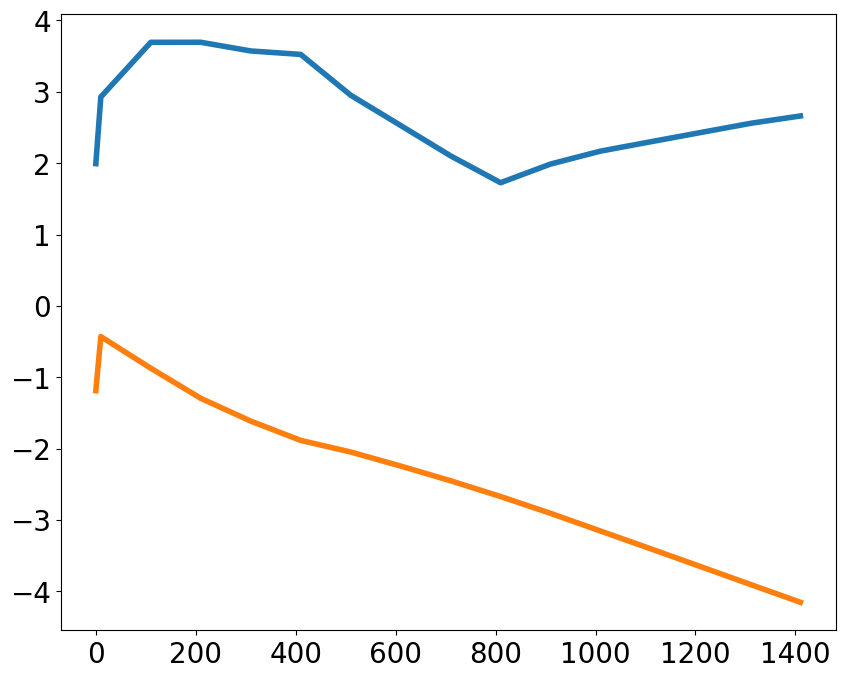

In [75]:
# plt.semilogy(1e3*np.append(0,depths),hadfluxes["SIBYLL-2.3c"])
uncertainties=pd.DataFrame({
    'lower':np.divide(np.amin(hadfluxes,axis=1)-hadfluxes["SIBYLL-2.3c"],hadfluxes["SIBYLL-2.3c"]),
    'upper':np.divide(np.amax(hadfluxes,axis=1)-hadfluxes["SIBYLL-2.3c"],hadfluxes["SIBYLL-2.3c"]),
})
plt.plot(1e3*np.append(0,depths),100*uncertainties['upper'])
plt.plot(1e3*np.append(0,depths),100*uncertainties['lower'])

In [78]:
uncertainties.to_csv('data/uncertainty_had.csv', index=False)

### cr

In [105]:
import crflux.models as pm
CRMODELS = [
    ((pm.GlobalSplineFitBeta, None), "GSF"), # GSF
    ((pm.GaisserStanevTilav, "3-gen"), "GST3"), # GST3
    ((pm.GaisserStanevTilav, "4-gen"), "GST4"), # GST4
    ((pm.HillasGaisser2012, "H3a"), "H3a"),# H3a
    ((pm.HillasGaisser2012, "H4a"), "H4a"), # H4a
    ((pm.CombinedGHandHG, "H3a"), "cH3a"),# cH3a
    ((pm.CombinedGHandHG, "H4a"), "cH4a"),# cH4a
]

In [107]:
crfluxes={k[1]:None for k in CRMODELS}
for cr in CRMODELS:
    s_fluxes = mts.calc_s_fluxes(
        primary_model = cr[0],
        interaction_model = "SIBYLL-2.3c", atmosphere = "MSIS00", location = "Wieliczka_Explosives", month = "December",output=True
    )
    s_flux_integrated=mts.calc_s_tot_flux(
        s_fluxes = s_fluxes,
        force = False,primary_model = cr[0], interaction_model = "SIBYLL-2.3c", 
        atmosphere = "MSIS00", location = "Wieliczka_Explosives", month = "December"
    )
    u_fluxes_integrated=[]
    for depth in depths: # in km w. e.
        mtc.set_vertical_depth(depth)
        u_fluxes_integrated.append(mtu.calc_u_tot_flux(
            s_fluxes = s_fluxes,
            force = False, survival_probability_tensor = None, 
            angles = mtc.angles, 
            E_th = 0, 
            primary_model = cr[0], interaction_model = "SIBYLL-2.3c", atmosphere = "MSIS00", location = "Wieliczka_Explosives", month = "December")
        )
    crfluxes[cr[1]]=np.append(s_flux_integrated,u_fluxes_integrated)
crfluxes=pd.DataFrame(crfluxes)

Calculating surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
MCEqRun::set_interaction_model(): SIBYLL23C
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::set_density_model(): Setting density profile to MSIS00 ('Wieliczka_Explosives', 'December')


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [02:51<00:00,  8.57s/it]


Finished calculating surface fluxes.
Surface fluxes written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Fluxes_Wieliczka_Explosives_December_SIBYLL-2.3c_GSF.txt.
Calculating total surface flux.
Calculating surface intensities.
Finished calculating surface intensities.
Surface intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Intensities_Wieliczka_Explosives_December_SIBYLL-2.3c_(<class 'crflux.models.GlobalSplineFitBeta'>, None).txt.
Finished calculating total surface flux.
Calculating underground fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Calculating underground intensities.
Finished calculating underground intensities.
Underground intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Intensities_sd.txt.
Ca

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [02:53<00:00,  8.68s/it]


Finished calculating surface fluxes.
Surface fluxes written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Fluxes_Wieliczka_Explosives_December_SIBYLL-2.3c_GST3.txt.
Calculating total surface flux.
Calculating surface intensities.
Finished calculating surface intensities.
Surface intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Intensities_Wieliczka_Explosives_December_SIBYLL-2.3c_(<class 'crflux.models.GaisserStanevTilav'>, '3-gen').txt.
Finished calculating total surface flux.
Calculating underground fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Calculating underground intensities.
Finished calculating underground intensities.
Underground intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Intensities_sd.txt.

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [02:51<00:00,  8.57s/it]


Finished calculating surface fluxes.
Surface fluxes written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Fluxes_Wieliczka_Explosives_December_SIBYLL-2.3c_GST4.txt.
Calculating total surface flux.
Calculating surface intensities.
Finished calculating surface intensities.
Surface intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Intensities_Wieliczka_Explosives_December_SIBYLL-2.3c_(<class 'crflux.models.GaisserStanevTilav'>, '4-gen').txt.
Finished calculating total surface flux.
Calculating underground fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Calculating underground intensities.
Finished calculating underground intensities.
Underground intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Intensities_sd.txt.

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [03:05<00:00,  9.30s/it]


Finished calculating surface fluxes.
Surface fluxes written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Fluxes_Wieliczka_Explosives_December_SIBYLL-2.3c_H3a.txt.
Calculating total surface flux.
Calculating surface intensities.
Finished calculating surface intensities.
Surface intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Intensities_Wieliczka_Explosives_December_SIBYLL-2.3c_(<class 'crflux.models.HillasGaisser2012'>, 'H3a').txt.
Finished calculating total surface flux.
Calculating underground fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Calculating underground intensities.
Finished calculating underground intensities.
Underground intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Intensities_sd.txt.
Cal

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [03:02<00:00,  9.11s/it]


Finished calculating surface fluxes.
Surface fluxes written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Fluxes_Wieliczka_Explosives_December_SIBYLL-2.3c_H4a.txt.
Calculating total surface flux.
Calculating surface intensities.
Finished calculating surface intensities.
Surface intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Intensities_Wieliczka_Explosives_December_SIBYLL-2.3c_(<class 'crflux.models.HillasGaisser2012'>, 'H4a').txt.
Finished calculating total surface flux.
Calculating underground fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Calculating underground intensities.
Finished calculating underground intensities.
Underground intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Intensities_sd.txt.
Cal

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [03:04<00:00,  9.23s/it]


Finished calculating surface fluxes.
Surface fluxes written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Fluxes_Wieliczka_Explosives_December_SIBYLL-2.3c_cH3a.txt.
Calculating total surface flux.
Calculating surface intensities.
Finished calculating surface intensities.
Surface intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Intensities_Wieliczka_Explosives_December_SIBYLL-2.3c_(<class 'crflux.models.CombinedGHandHG'>, 'H3a').txt.
Finished calculating total surface flux.
Calculating underground fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Calculating underground intensities.
Finished calculating underground intensities.
Underground intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Intensities_sd.txt.
Calc

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [03:06<00:00,  9.30s/it]


Finished calculating surface fluxes.
Surface fluxes written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Fluxes_Wieliczka_Explosives_December_SIBYLL-2.3c_cH4a.txt.
Calculating total surface flux.
Calculating surface intensities.
Finished calculating surface intensities.
Surface intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Intensities_Wieliczka_Explosives_December_SIBYLL-2.3c_(<class 'crflux.models.CombinedGHandHG'>, 'H4a').txt.
Finished calculating total surface flux.
Calculating underground fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Calculating underground intensities.
Finished calculating underground intensities.
Underground intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Intensities_sd.txt.
Calc

In [110]:
crfluxes

,GSF,GST3,GST4,H3a,H4a,cH3a,cH4a
0,1.393712e-02,1.066016e-02,1.065600e-02,1.159871e-02,1.185875e-02,1.398969e-02,1.400381e-02
1,2.167992e-04,2.323526e-04,2.321174e-04,2.309565e-04,2.365397e-04,2.353115e-04,2.388941e-04
2,5.858560e-05,6.239612e-05,6.234011e-05,6.239308e-05,6.389294e-05,6.441570e-05,6.517437e-05
3,3.080885e-05,3.278130e-05,3.275184e-05,3.279022e-05,3.357851e-05,3.387612e-05,3.427583e-05
4,2.105097e-05,2.240021e-05,2.237981e-05,2.239778e-05,2.293659e-05,2.311949e-05,2.340003e-05
5,1.964944e-05,2.090824e-05,2.088915e-05,2.090368e-05,2.140666e-05,2.157431e-05,2.183780e-05
6,1.063300e-05,1.134807e-05,1.133700e-05,1.131045e-05,1.158345e-05,1.159424e-05,1.175758e-05
7,6.950415e-06,7.428121e-06,7.420539e-06,7.391589e-06,7.570378e-06,7.545276e-06,7.661025e-06
8,4.619590e-06,4.942706e-06,4.937430e-06,4.911375e-06,5.030424e-06,4.992969e-06,5.075878e-06
9,3.132062e-06,3.353495e-06,3.349757e-06,3.328617e-06,3.409464e-06,3.371338e-06,3.431404e-06


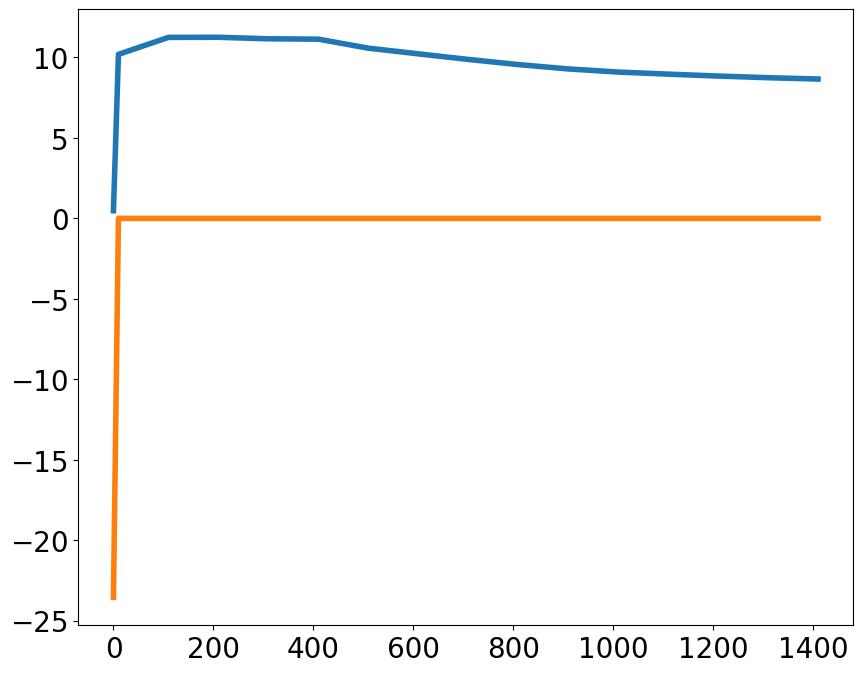

In [112]:
uncertainties=pd.DataFrame({
    'lower':np.divide(np.amin(crfluxes,axis=1)-crfluxes["GSF"],crfluxes["GSF"]),
    'upper':np.divide(np.amax(crfluxes,axis=1)-crfluxes["GSF"],crfluxes["GSF"]),
})
plt.plot(1e3*np.append(0,depths),100*uncertainties['upper'])
plt.plot(1e3*np.append(0,depths),100*uncertainties['lower'])

In [113]:
uncertainties.to_csv('data/uncertainty_cr.csv', index=False)

### seasonal

In [24]:
MONTHS = [
            'January',
            'February',
            'March',
            'April',
            'May',
            'June',
            'July',
            'August',
            'September',
            'October',
            'November',
            'December',
]
seasonfluxes={k:None for k in MONTHS}
for mon in MONTHS:
    s_flux_integrated=mts.calc_s_tot_flux(
        force = False,primary_model = "GSF", interaction_model = "SIBYLL-2.3c", 
        atmosphere = "MSIS00", location = "Wieliczka_Explosives", month = mon, 
    )
    u_fluxes_integrated=[]
    for depth in depths: # in km w. e.
        mtc.set_vertical_depth(depth)
        u_fluxes_integrated.append(mtu.calc_u_tot_flux(
            force = False, s_fluxes = None, survival_probability_tensor = None, 
            angles = mtc.angles, 
            E_th = 0, 
            primary_model = "GSF", interaction_model = "SIBYLL-2.3c", atmosphere = "MSIS00", location = "Wieliczka_Explosives", month = mon)
        )
    seasonfluxes[mon]=np.append(s_flux_integrated,u_fluxes_integrated)
seasonfluxes=pd.DataFrame(seasonfluxes)
seasonfluxes['mean']=np.array(np.mean(seasonfluxes,axis=1))

Calculating total surface flux.
Calculating surface intensities.
Loading surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
Loaded surface fluxes.
Finished calculating surface intensities.
Surface intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Intensities_Wieliczka_Explosives_January_SIBYLL-2.3c_GSF.txt.
Finished calculating total surface flux.
Calculating underground fluxes.
Loading surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
Loaded surface fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Calculating underground intensities.
Finished calculating underground intensities.
Underground intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Intensities_sd.txt.
Calculating underground fluxes.
Loading surface fluxes for Wielicz

No surface flux matrix currently exists for these models. Would you like to create one (y/n)?:  y


Calculating surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
MCEqRun::set_interaction_model(): SIBYLL23C
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::set_density_model(): Setting density profile to MSIS00 ('Wieliczka_Explosives', 'February')


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [02:47<00:00,  8.39s/it]


Finished calculating surface fluxes.
Surface fluxes written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Fluxes_Wieliczka_Explosives_February_SIBYLL-2.3c_GSF.txt.
Finished calculating surface intensities.
Surface intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Intensities_Wieliczka_Explosives_February_SIBYLL-2.3c_GSF.txt.
Finished calculating total surface flux.
Calculating underground fluxes.
Loading surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
Loaded surface fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Calculating underground intensities.
Finished calculating underground intensities.
Underground intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Intensities_sd.txt.
Calculating under

No surface flux matrix currently exists for these models. Would you like to create one (y/n)?:  y


Calculating surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
MCEqRun::set_interaction_model(): SIBYLL23C
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::set_density_model(): Setting density profile to MSIS00 ('Wieliczka_Explosives', 'March')


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [02:46<00:00,  8.30s/it]


Finished calculating surface fluxes.
Surface fluxes written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Fluxes_Wieliczka_Explosives_March_SIBYLL-2.3c_GSF.txt.
Finished calculating surface intensities.
Surface intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Intensities_Wieliczka_Explosives_March_SIBYLL-2.3c_GSF.txt.
Finished calculating total surface flux.
Calculating underground fluxes.
Loading surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
Loaded surface fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Calculating underground intensities.
Finished calculating underground intensities.
Underground intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Intensities_sd.txt.
Calculating underground

No surface flux matrix currently exists for these models. Would you like to create one (y/n)?:  y


Calculating surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
MCEqRun::set_interaction_model(): SIBYLL23C
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::set_density_model(): Setting density profile to MSIS00 ('Wieliczka_Explosives', 'April')


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [02:44<00:00,  8.20s/it]


Finished calculating surface fluxes.
Surface fluxes written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Fluxes_Wieliczka_Explosives_April_SIBYLL-2.3c_GSF.txt.
Finished calculating surface intensities.
Surface intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Intensities_Wieliczka_Explosives_April_SIBYLL-2.3c_GSF.txt.
Finished calculating total surface flux.
Calculating underground fluxes.
Loading surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
Loaded surface fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Calculating underground intensities.
Finished calculating underground intensities.
Underground intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Intensities_sd.txt.
Calculating underground

No surface flux matrix currently exists for these models. Would you like to create one (y/n)?:  y


Calculating surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
MCEqRun::set_interaction_model(): SIBYLL23C
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::set_density_model(): Setting density profile to MSIS00 ('Wieliczka_Explosives', 'May')


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [02:46<00:00,  8.31s/it]


Finished calculating surface fluxes.
Surface fluxes written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Fluxes_Wieliczka_Explosives_May_SIBYLL-2.3c_GSF.txt.
Finished calculating surface intensities.
Surface intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Intensities_Wieliczka_Explosives_May_SIBYLL-2.3c_GSF.txt.
Finished calculating total surface flux.
Calculating underground fluxes.
Loading surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
Loaded surface fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Calculating underground intensities.
Finished calculating underground intensities.
Underground intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Intensities_sd.txt.
Calculating underground flu

No surface flux matrix currently exists for these models. Would you like to create one (y/n)?:  y


Calculating surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
MCEqRun::set_interaction_model(): SIBYLL23C
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::set_density_model(): Setting density profile to MSIS00 ('Wieliczka_Explosives', 'June')


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [02:49<00:00,  8.49s/it]


Finished calculating surface fluxes.
Surface fluxes written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Fluxes_Wieliczka_Explosives_June_SIBYLL-2.3c_GSF.txt.
Finished calculating surface intensities.
Surface intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Intensities_Wieliczka_Explosives_June_SIBYLL-2.3c_GSF.txt.
Finished calculating total surface flux.
Calculating underground fluxes.
Loading surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
Loaded surface fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Calculating underground intensities.
Finished calculating underground intensities.
Underground intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Intensities_sd.txt.
Calculating underground f

No surface flux matrix currently exists for these models. Would you like to create one (y/n)?:  y


Calculating surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
MCEqRun::set_interaction_model(): SIBYLL23C
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::set_density_model(): Setting density profile to MSIS00 ('Wieliczka_Explosives', 'July')


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [02:47<00:00,  8.35s/it]


Finished calculating surface fluxes.
Surface fluxes written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Fluxes_Wieliczka_Explosives_July_SIBYLL-2.3c_GSF.txt.
Finished calculating surface intensities.
Surface intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Intensities_Wieliczka_Explosives_July_SIBYLL-2.3c_GSF.txt.
Finished calculating total surface flux.
Calculating underground fluxes.
Loading surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
Loaded surface fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Calculating underground intensities.
Finished calculating underground intensities.
Underground intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Intensities_sd.txt.
Calculating underground f

No surface flux matrix currently exists for these models. Would you like to create one (y/n)?:  y


Calculating surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
MCEqRun::set_interaction_model(): SIBYLL23C
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::set_density_model(): Setting density profile to MSIS00 ('Wieliczka_Explosives', 'August')


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [02:46<00:00,  8.34s/it]


Finished calculating surface fluxes.
Surface fluxes written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Fluxes_Wieliczka_Explosives_August_SIBYLL-2.3c_GSF.txt.
Finished calculating surface intensities.
Surface intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Intensities_Wieliczka_Explosives_August_SIBYLL-2.3c_GSF.txt.
Finished calculating total surface flux.
Calculating underground fluxes.
Loading surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
Loaded surface fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Calculating underground intensities.
Finished calculating underground intensities.
Underground intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Intensities_sd.txt.
Calculating undergrou

No surface flux matrix currently exists for these models. Would you like to create one (y/n)?:  y


Calculating surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
MCEqRun::set_interaction_model(): SIBYLL23C
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::set_density_model(): Setting density profile to MSIS00 ('Wieliczka_Explosives', 'September')


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [02:56<00:00,  8.82s/it]


Finished calculating surface fluxes.
Surface fluxes written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Fluxes_Wieliczka_Explosives_September_SIBYLL-2.3c_GSF.txt.
Finished calculating surface intensities.
Surface intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Intensities_Wieliczka_Explosives_September_SIBYLL-2.3c_GSF.txt.
Finished calculating total surface flux.
Calculating underground fluxes.
Loading surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
Loaded surface fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Calculating underground intensities.
Finished calculating underground intensities.
Underground intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Intensities_sd.txt.
Calculating und

No surface flux matrix currently exists for these models. Would you like to create one (y/n)?:  y


Calculating surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
MCEqRun::set_interaction_model(): SIBYLL23C
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::set_density_model(): Setting density profile to MSIS00 ('Wieliczka_Explosives', 'October')


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [02:58<00:00,  8.94s/it]


Finished calculating surface fluxes.
Surface fluxes written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Fluxes_Wieliczka_Explosives_October_SIBYLL-2.3c_GSF.txt.
Finished calculating surface intensities.
Surface intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Intensities_Wieliczka_Explosives_October_SIBYLL-2.3c_GSF.txt.
Finished calculating total surface flux.
Calculating underground fluxes.
Loading surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
Loaded surface fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Calculating underground intensities.
Finished calculating underground intensities.
Underground intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Intensities_sd.txt.
Calculating undergr

No surface flux matrix currently exists for these models. Would you like to create one (y/n)?:  y


Calculating surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
MCEqRun::set_interaction_model(): SIBYLL23C
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::set_density_model(): Setting density profile to MSIS00 ('Wieliczka_Explosives', 'November')


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [03:04<00:00,  9.23s/it]


Finished calculating surface fluxes.
Surface fluxes written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Fluxes_Wieliczka_Explosives_November_SIBYLL-2.3c_GSF.txt.
Finished calculating surface intensities.
Surface intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Intensities_Wieliczka_Explosives_November_SIBYLL-2.3c_GSF.txt.
Finished calculating total surface flux.
Calculating underground fluxes.
Loading surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
Loaded surface fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Calculating underground intensities.
Finished calculating underground intensities.
Underground intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Intensities_sd.txt.
Calculating under

No surface flux matrix currently exists for these models. Would you like to create one (y/n)?:  y


Calculating surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
MCEqRun::set_interaction_model(): SIBYLL23C
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::set_density_model(): Setting density profile to MSIS00 ('Wieliczka_Explosives', 'December')


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [02:56<00:00,  8.85s/it]


Finished calculating surface fluxes.
Surface fluxes written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Fluxes_Wieliczka_Explosives_December_SIBYLL-2.3c_GSF.txt.
Finished calculating surface intensities.
Surface intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/surface/Surface_Intensities_Wieliczka_Explosives_December_SIBYLL-2.3c_GSF.txt.
Finished calculating total surface flux.
Calculating underground fluxes.
Loading surface fluxes for Wieliczka_Explosives using GSF and SIBYLL-2.3c.
Loaded surface fluxes.
Survival probabilities already loaded for rock with density 2.65 gcm^-3 and 100000 muons.
Finished calculating underground fluxes.
Calculating underground intensities.
Finished calculating underground intensities.
Underground intensities written to /home/kakiczi/miniconda3/envs/mute/lib/python3.11/site-packages/mute/data/underground/Example_Underground_Intensities_sd.txt.
Calculating under

In [26]:
season_arr=[seasonfluxes[mon] for mon in MONTHS]

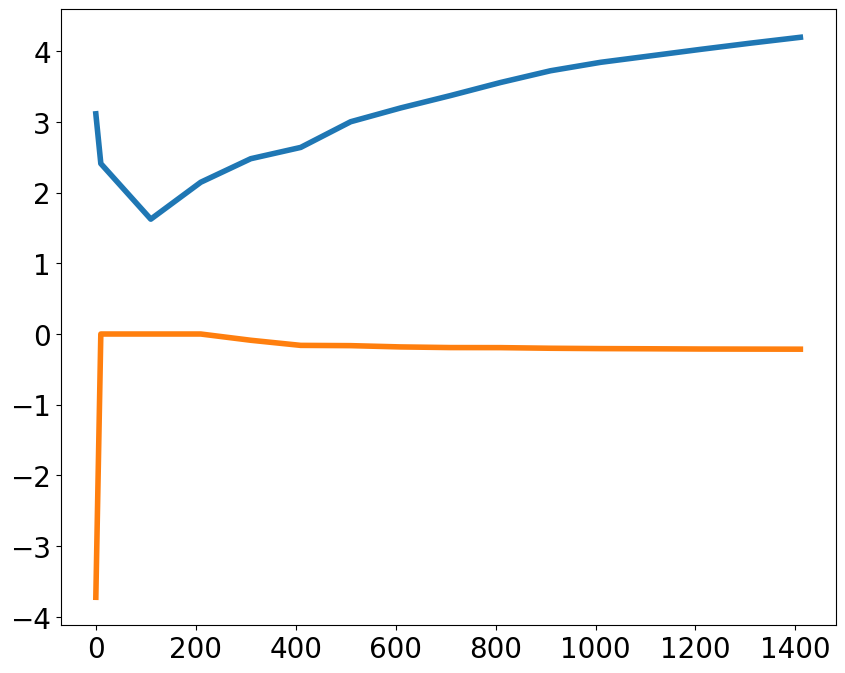

In [115]:
uncertainties=pd.DataFrame({
    'lower':np.divide(np.amin(seasonfluxes,axis=1)-seasonfluxes["December"],seasonfluxes["December"]),
    'upper':np.divide(np.amax(seasonfluxes,axis=1)-seasonfluxes["December"],seasonfluxes["December"]),
})
plt.plot(1e3*np.append(0,depths),100*uncertainties['upper'])
plt.plot(1e3*np.append(0,depths),100*uncertainties['lower'])

In [116]:
uncertainties.to_csv('data/uncertainty_monthly.csv', index=False)

January 	 0.00029006080127640674
February 	 0.0004609218799808926
March 	 0.0005095837591834017
April 	 0.0003734107990194824
May 	 8.777887523273568e-05
June 	 0.00020408002571120358
July 	 0.00035348424056148945
August 	 0.0004475648827926196
September 	 0.0003922178970784343
October 	 0.00026180674740386304
November 	 0.0001379783880791436
December 	 7.857910410395296e-05
minimum: 7.857910410395296e-05 (December)


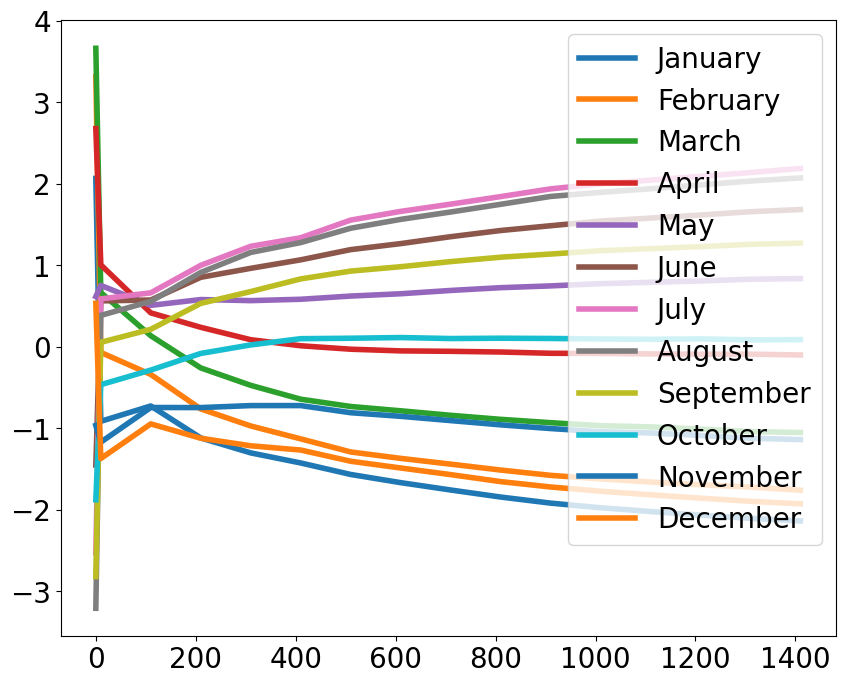

In [69]:
min_diff=np.inf
for mon in MONTHS:
    plt.plot(1e3*np.append(0,depths),100*np.divide(seasonfluxes[mon]-np.mean(season_arr,axis=0),np.mean(season_arr,axis=0)),label=mon)
    temp=np.sum(np.abs(seasonfluxes[mon]-np.mean(season_arr,axis=0)))
    print(mon,"\t",temp)
    min_diff=min(min_diff,temp)
    plt.legend()
for mon in MONTHS:
    if np.sum(np.abs(seasonfluxes[mon]-seasonfluxes['mean']))==min_diff:
        print('minimum:',min_diff,'('+mon+')')

In [114]:
seasonfluxes

,January,February,March,April,May,June,July,August,September,October,November,December,mean
0,1.414963e-02,1.432292e-02,1.437096e-02,1.423434e-02,1.394868e-02,1.366211e-02,1.351310e-02,1.341842e-02,1.347233e-02,1.360297e-02,1.372936e-02,1.393712e-02,1.386349e-02
1,2.178034e-04,2.196604e-04,2.212749e-04,2.220226e-04,2.214679e-04,2.210509e-04,2.211041e-04,2.206600e-04,2.199331e-04,2.187915e-04,2.172409e-04,2.167992e-04,2.198174e-04
2,5.871563e-05,5.894422e-05,5.922504e-05,5.939118e-05,5.944571e-05,5.948466e-05,5.953682e-05,5.947444e-05,5.927196e-05,5.897612e-05,5.870452e-05,5.858560e-05,5.914632e-05
3,3.081003e-05,3.092099e-05,3.107775e-05,3.123296e-05,3.133912e-05,3.142412e-05,3.146988e-05,3.144265e-05,3.132439e-05,3.113310e-05,3.092608e-05,3.080885e-05,3.115916e-05
4,2.103239e-05,2.110278e-05,2.120903e-05,2.132833e-05,2.143051e-05,2.151499e-05,2.157264e-05,2.155655e-05,2.145428e-05,2.131472e-05,2.115607e-05,2.105097e-05,2.131027e-05
5,1.961787e-05,1.967675e-05,1.977356e-05,1.990406e-05,2.001761e-05,2.011387e-05,2.016777e-05,2.015602e-05,2.006731e-05,1.992135e-05,1.975798e-05,1.964944e-05,1.990196e-05
6,1.061552e-05,1.064529e-05,1.070546e-05,1.078124e-05,1.085157e-05,1.091302e-05,1.095209e-05,1.094132e-05,1.088460e-05,1.079577e-05,1.069722e-05,1.063300e-05,1.078467e-05
7,6.937731e-06,6.958741e-06,6.999922e-06,7.051783e-06,7.101232e-06,7.144644e-06,7.172538e-06,7.165621e-06,7.124641e-06,7.063333e-06,6.995141e-06,6.950415e-06,7.055479e-06
8,4.610737e-06,4.625624e-06,4.653750e-06,4.690589e-06,4.725634e-06,4.756587e-06,4.775326e-06,4.770805e-06,4.742251e-06,4.697948e-06,4.650694e-06,4.619590e-06,4.693295e-06
9,3.126031e-06,3.136574e-06,3.156392e-06,3.182700e-06,3.207837e-06,3.230169e-06,3.243426e-06,3.240413e-06,3.219743e-06,3.188089e-06,3.154237e-06,3.132062e-06,3.184806e-06


### total

In [19]:
len(depths)+1

15

In [20]:
uncertainties=pd.DataFrame({
    'lower':np.zeros(len(depths)+1),
    'upper':np.zeros(len(depths)+1),
})
for key in ['cr','had','monthly']:
    for type in ['lower','upper']:
        uncertainties[type]+=pd.read_csv('data/uncertainty_'+key+'.csv')[type]
uncertainties.to_csv('data/uncertainty_total.csv', index=False)

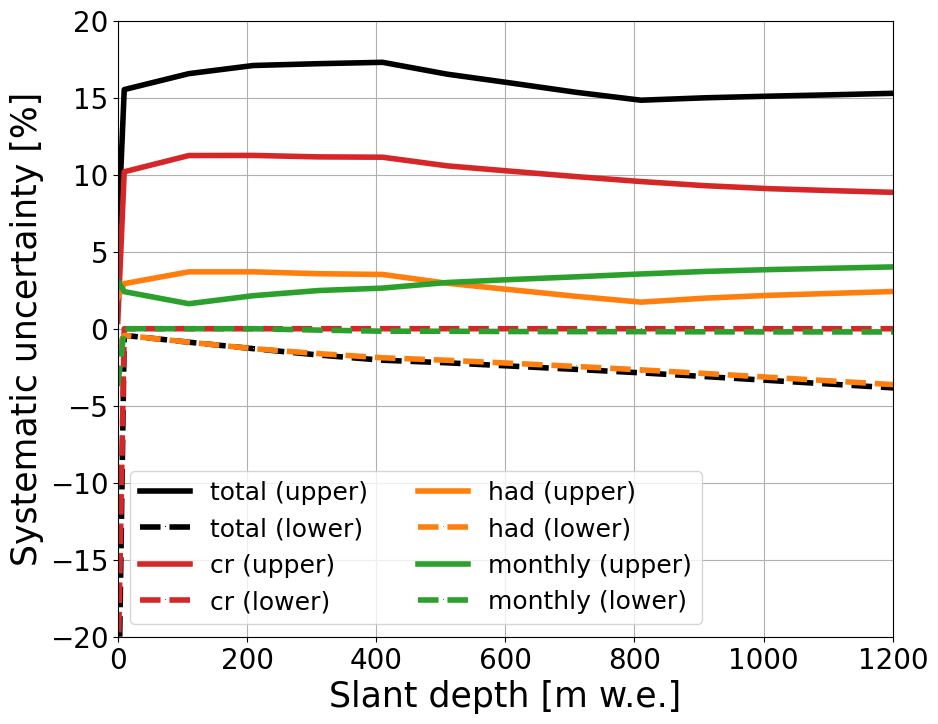

In [41]:
plt.figure(facecolor = "white")
plt.grid()
CLRS=np.append('k',color_list)
for i,key in enumerate(['total','cr','had','monthly']):
    plt.plot(1e3*np.append(0,depths),100*pd.read_csv('data/uncertainty_'+key+'.csv')['upper'],color=CLRS[i],label=key+' (upper)')
    plt.plot(1e3*np.append(0,depths),100*pd.read_csv('data/uncertainty_'+key+'.csv')['lower'],color=CLRS[i],label=key+' (lower)',ls='--')
plt.xlabel("Slant depth [m w.e.]")
plt.ylabel("Systematic uncertainty [%]")
plt.xlim(0,1200)
plt.ylim(-20,20)
plt.legend(fontsize=18,ncols=2)
for fmt in ['png','pdf','svg']:
    plt.savefig('plots/systematics.'+fmt)
plt.show()